In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from SpatialFusion import SpatialFusion


In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/usr/lib/R'

In [5]:
n_clusters = 20


In [4]:
dataset = '3.Human_Breast_Cancer'

In [6]:
# read data
file_fold = '/data/Data/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# define model
model = SpatialFusion.SpatialFusion(adata, device=device,epochs=1000,random_seed=1999)

In [9]:
# train model
adata = model.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Begin to train ST data...


/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/data/SpatialFusion-main/SpatialFusion/model.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 1000/1000 [00:27<00:00, 35.76it/s]


Optimization finished for ST data!


In [10]:
# set radius to specify the number of neighbors considered during refinement
radius = 30

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from SpatialFusion.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [11]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['ground_truth']
adata.obs['ground_truth'] = df_meta_layer.values

In [12]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import (
    homogeneity_score, mutual_info_score, v_measure_score,
    adjusted_mutual_info_score, normalized_mutual_info_score,
    adjusted_rand_score
)

# 过滤掉 NA 节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# 计算 ARI 指标
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

# 计算其他聚类指标
# homogeneity = homogeneity_score(adata.obs['ground_truth'], adata.obs['domain'])
# mutual_info = mutual_info_score(adata.obs['ground_truth'], adata.obs['domain'])
# v_measure = v_measure_score(adata.obs['ground_truth'], adata.obs['domain'])
ami = adjusted_mutual_info_score(adata.obs['ground_truth'], adata.obs['domain'])
nmi = normalized_mutual_info_score(adata.obs['ground_truth'], adata.obs['domain'])

# 将指标存储到 adata.uns 中
# adata.uns['homogeneity'] = homogeneity
# adata.uns['mutual_info'] = mutual_info
# adata.uns['v_measure'] = v_measure
adata.uns['AMI'] = ami
adata.uns['NMI'] = nmi

# 输出结果
print('Dataset:', dataset)
print('ARI:', ARI)
# print('Homogeneity:', homogeneity)
# print('Mutual Info:', mutual_info)
# print('V-measure:', v_measure)
print('AMI:', ami)
print('NMI:', nmi)


/tmp/ipykernel_57316/1281848126.py:14: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


Dataset: 3.Human_Breast_Cancer
ARI: 0.6103132548261565
AMI: 0.7002210301721496
NMI: 0.7053824480114932


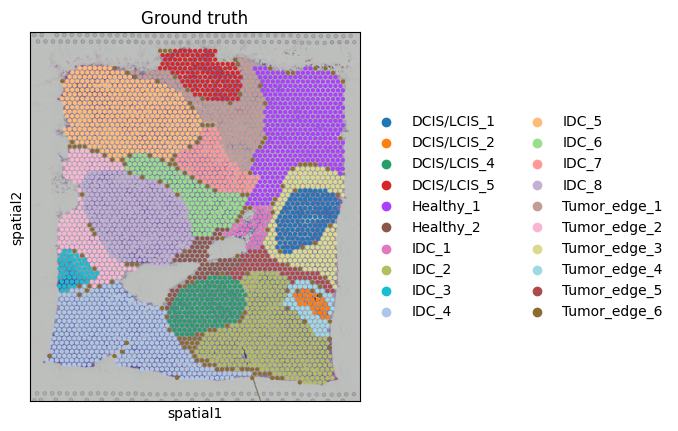

In [13]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth",],
              title=["Ground truth",],
              show=True,
              size=1.3)

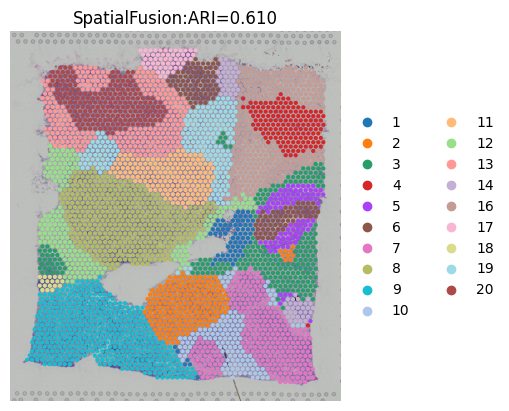

In [15]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["domain"],
              title=["SpatialFusion:ARI=%.3f"%ARI],
              show=True,
              size=1.3,
              frameon=False,
            #   legend_loc='left'
              )
